# Environmental Sensor Calibration Workflow using Figaro TGS2611-E00 Methane Sensors
#### Clark Jackson, Dr. Jacob Hosen, Zaven Arra

Freshwater methane fluxes are becoming increasingly popular in the scientific community because of the [knowledge gap](https://www.globalcarbonproject.org/methanebudget/) lying within the subject. Methane is a potent greenhouse gas that has a lifespan of about 10 years but a global warming potential (GWP) of nearly 25x that of carbon dioxide. Furthermore, of all natural methane sources, wetlands appear to be the largest contributor. These factors are causing scientists to invest in sensor development to accurately determine methane fluxes in wetlands.

<div>
<img src="images/MethaneInfographic2024-small.png" width="500"/>
</div>



However, although current sensor technology exists, it is either rudimentary or specific to certain environmental attributes. In collaboration with the [RRIV (River Restoration Intelligence and Verification) program](https://www.rriv.org/), we are developing sensors to track methane fluxes in wetland environemnts. This module will focus on the calibration phase of this research, seeing as how the calibration process in of itself is an obstacle in the path of sensor advancement. Historically, each sensor required individual calibration and then was only able to be used under the model derived specifically from that sensor. Instead, we are attempting to develop a semi-generalized model for these sensors that can be used to cut back on time and resources for calibration.

As stated in the title, this calibration workflow will use Figaro Methane Sensors to represent the processes. The sensor technical information can be found [here](https://asset.conrad.com/media10/add/160267/c1/-/en/000183302DS01/datenblatt-183302-figaro-gas-sensor-tgs-2611-passend-fuer-gase-methan-o-x-h-92-mm-x-78-mm.pdf). As part of this workflow, it is essential to record true data points alongside sensor data points. To account for this requirement, we utilized an ABB Microportable Gas Analyzer to provide real-time concentration values of methane. More information on that device can be found by accessing [this link](https://new.abb.com/products/measurement-products/analytical/laser-gas-analyzers/laser-analyzers/lgr-icos-portable-analyzers/lgr-icos-microportable-analyzers-gla131-series).

## Load in the necessary packages

In [2]:
library(dplyr)
library(purrr)
library(tidyverse)
library(lubridate)
library(mgcv)
library(ggpubr)

## Cleaning and organizing our raw sensor and reference data

In [3]:
ch4_1 <- "/home/clark-jackson/Documents/CH4_data/2025/CH4_Jan21_parent/RRIV_data/CH1.1.13"
ch4_2 <- "/home/clark-jackson/Documents/CH4_data/2025/CH4_Jan21_parent/RRIV_data/CH1.3.13"
ch4_3 <- "/home/clark-jackson/Documents/CH4_data/2025/CH4_Jan21_parent/RRIV_data/CH1.4.13"
ch4_4 <- "/home/clark-jackson/Documents/CH4_data/2025/CH4_Jan21_parent/RRIV_data/CH1.5.13"

The code below is creating a new dataframe using the raw methane data we imported above, but including only the data we are filtering for. The code defines the location it will find the data, to only read .csv files, and reading each column as a character without skipping any. This action creates 5 new dataframes of organized data that we are ready to use! We can ignore the warning messages that are produced by this code.

In [ ]:
ch4_1_d <-
    list.files(path = ch4_1,
               pattern = "\\.CSV$",
               full.names = T) %>%
    map_df(~read_csv(., col_types = cols(.default = "c"),skip=0))
ch4_2_d <-
    list.files(path = ch4_2,
               pattern = "\\.CSV$",
               full.names = T) %>%
    map_df(~read_csv(., col_types = cols(.default = "c"),skip=0))
ch4_3_d <-
    list.files(path = ch4_3,
               pattern = "\\.CSV$",
               full.names = T) %>%
    map_df(~read_csv(., col_types = cols(.default = "c"),skip=0))
ch4_4_d <-
    list.files(path = ch4_4,
               pattern = "\\.CSV$",
               full.names = T) %>%
    map_df(~read_csv(., col_types = cols(.default = "c"),skip=0))

We repeat the same code as above except for our ABB microportable gas analyzer (reference) data.

In [5]:
abb_dat <- "/home/clark-jackson/Documents/CH4_data/2025/CH4_Jan21_parent/ABB_data/21-23_files"
abb_dat_d <-
    list.files(path = abb_dat,
               pattern = "\\.txt$",
               full.names = T) %>%
    map_df(~read_csv(., col_types = cols(.default = "c"),skip=1))

We want to manipulate some of our reference data, so we are going to create a new column called "dtp" to serve as our time value as well as turn a couple columns from character type to numeric type. This change will make analysis easier, since we cannot compare character values with numeric values.

In [6]:
abb_dat_d$dtp<-as.POSIXct(abb_dat_d$Time,tz="UTC")
abb_dat_d$ch4_abb<-as.numeric(abb_dat_d$"[CH4]_ppm")
abb_dat_d$temp_c_abb<-as.numeric(abb_dat_d$GasT_C)

Now let's plot our ABB reference data to visualize the true diffusion curve of the methane we injected for this experiment!

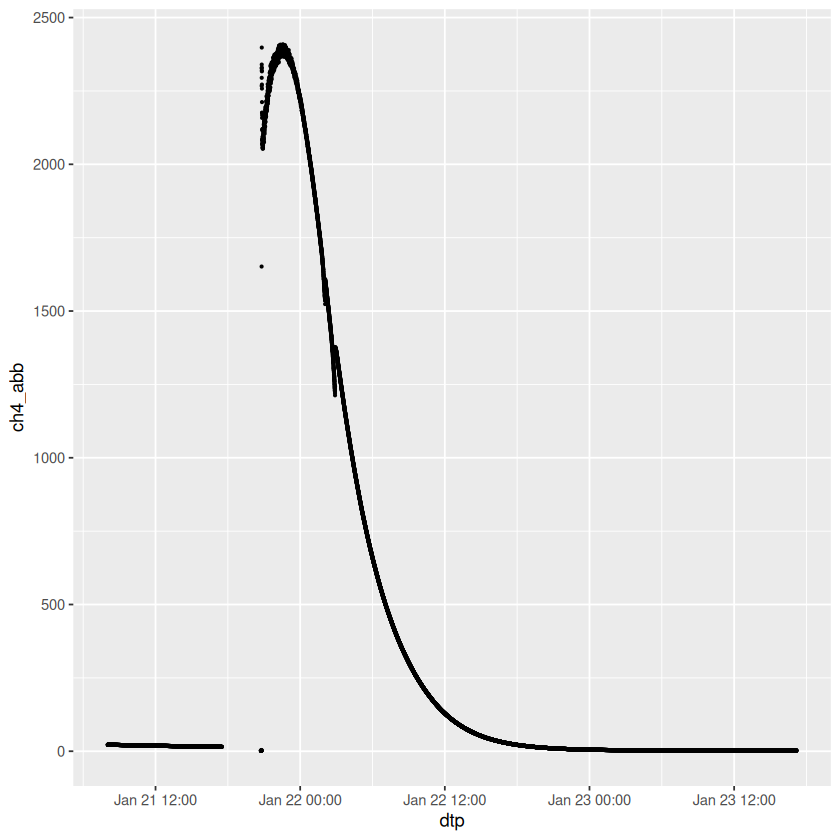

In [6]:
ggplot(abb_dat_d,aes(x=dtp,y=ch4_abb))+
geom_point(size=0.5)

We have just visualized a diffusion time curve for our methane trial! However, the ABB device was turned on before the trial began (i.e., before methane was injected), resulting in a stretch of low values prior to the methane injection. This will cause confusion and errors in our statistical analyses later down the line, so it's best to deal with that right now. Let's use the 'subset()' command to crop our data range with the code below.

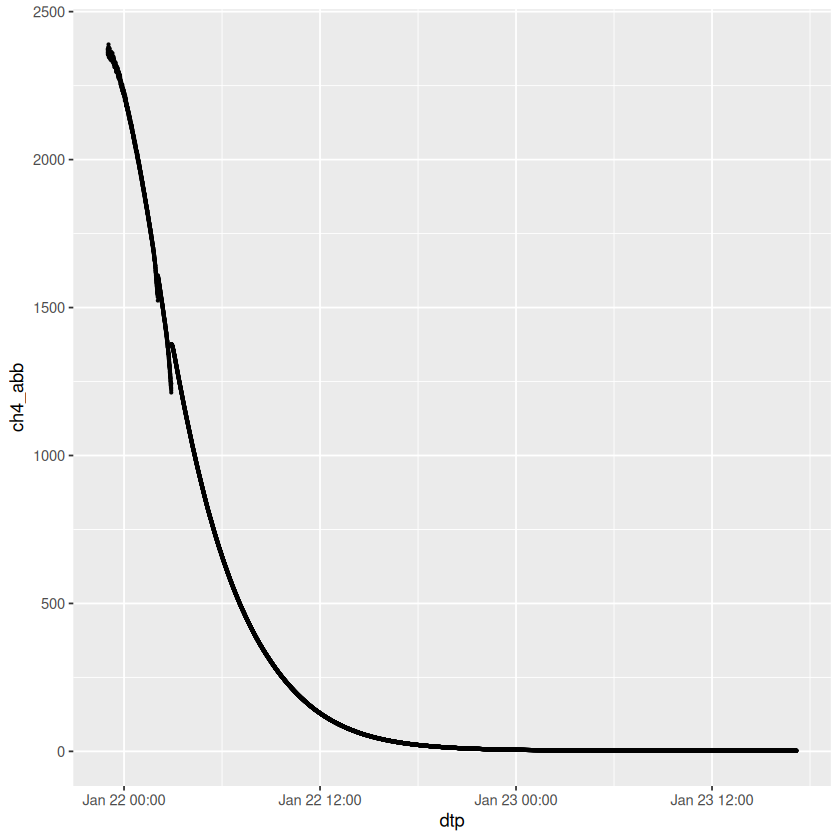

In [10]:
abb_clean <- subset(abb_dat_d, dtp >= as.POSIXct("2025-01-21 18:00:00")) # we want to keep all values after January 21 6:00pm
ggplot(abb_clean,aes(x=dtp,y=ch4_abb))+
geom_point(size=0.5)

That's much better; we now have a clean curve with accurate data we can use for the analyses.

The next step is to modify our methane sensor data in few ways, then use the 'approx()' function to apply a linear approximation between the ABB reference values and our raw sensor values. This creates a linear relationship between the two datasets and fills in any gaps using the existing relationship, which will help us with the calibration later on down the line. The first thing we will do is use the 'subset()' function to weed out any rows of data that are glitchy (if the time.s column in the data set has more than 20 values, we know it is not accurate). We will then transform that column to an integer class and nest it in a new column we've called dtp (sticking with our time value convention). 

In [12]:
ch4_1_keep<-subset(ch4_1_d,nchar(ch4_1_d$time.s)<20 & type=="raw")
ch4_1_keep$dtp<-as_datetime(as.integer(ch4_1_keep$time.s))

Next we will use the 'approx()' function mentioned above to create the relationship between raw and reference methane values. We will nest the approximation in a new column of this sensors dataframe called ch4_abb. We then ensure that our ch4_raw column is a numeric class type.

In [13]:
ch4_1_keep$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_1_keep$dtp)$y
ch4_1_keep$ch4_raw<-as.numeric(ch4_1_keep$ch4_raw)

Finally we will produce a simple plot with our ch4_abb values on the x-axis and our ch4_raw values on the y-axis, displaying our linear approximation. We will term that plot as an object called plot_1, and we will print all 4 sensor plots at the end of this step

In [14]:
plot_1<-ggplot(ch4_1_keep,aes(ch4_abb,ch4_raw))+
  geom_point(size=0.5)+ggtitle("CH4-1.1.13 Jan 21-23 2025")+theme(plot.title = element_text(hjust=0.5))

To simplify the workflow, we will run this code for each sensor in the same cell then use the 'ggarrange()' function to display all four of our plots at once. For now, we must complete the above steps for each of the remaining three sensors.

Warning message:
“Removed 391 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 378 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 372 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 368 rows containing missing values or values outside the scale range
(`geom_point()`).”


$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

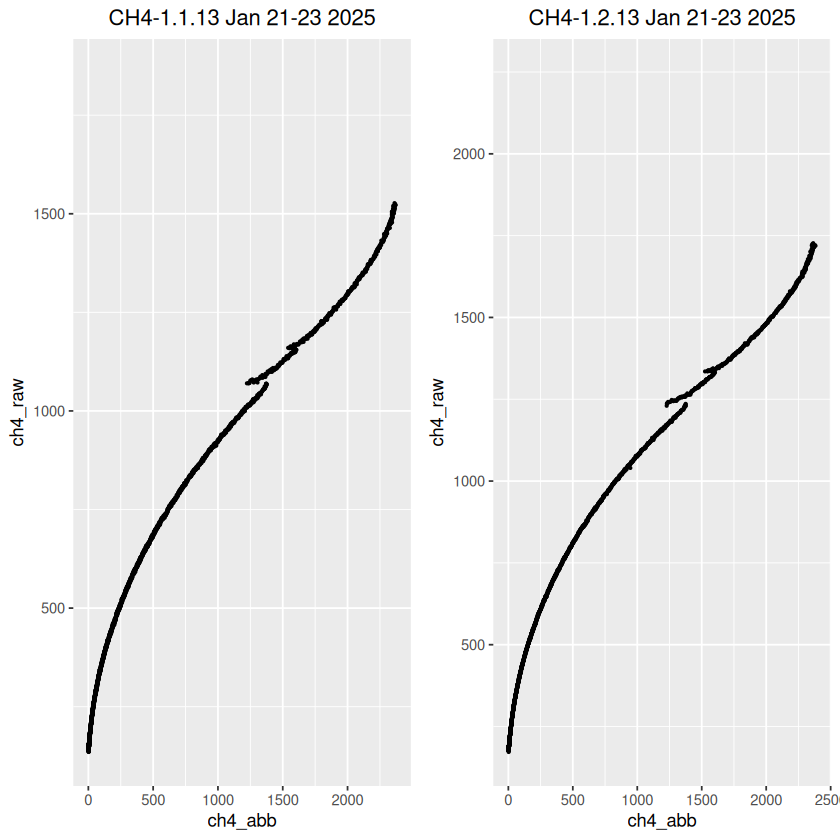

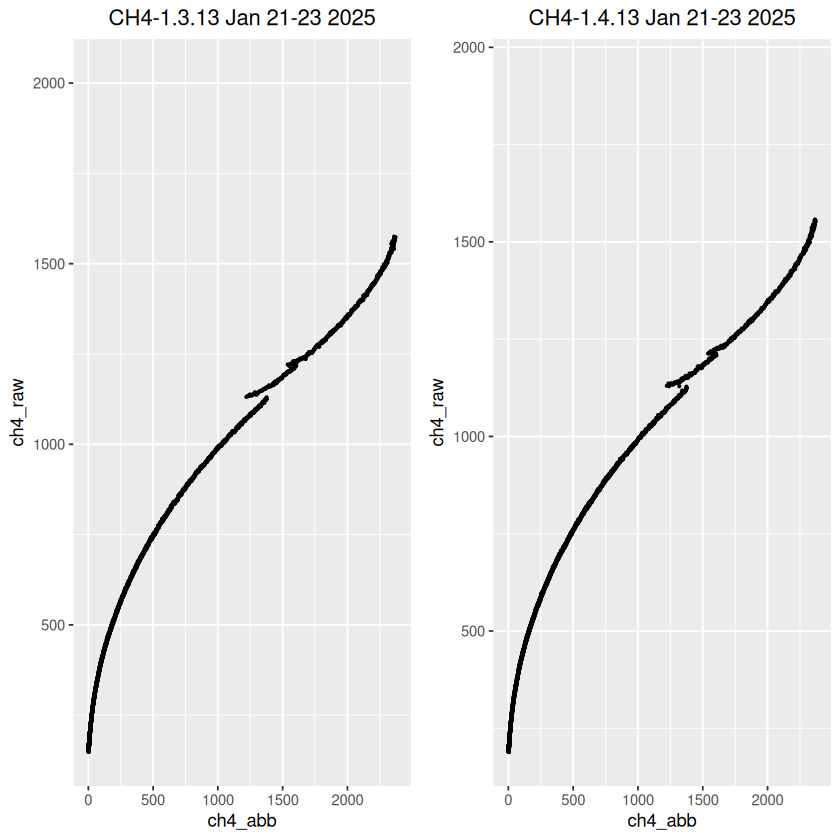

In [15]:
ch4_2_keep<-subset(ch4_2_d,nchar(ch4_2_d$time.s)<20 & type=="raw")
ch4_2_keep$dtp<-as_datetime(as.integer(ch4_2_keep$time.s))

ch4_2_keep$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_2_keep$dtp)$y
ch4_2_keep$ch4_raw<-as.numeric(ch4_2_keep$ch4_raw)

plot_2<-ggplot(ch4_2_keep,aes(ch4_abb,ch4_raw))+
  geom_point(size=0.5)+ggtitle("CH4-1.2.13 Jan 21-23 2025")+theme(plot.title = element_text(hjust=0.5))


ch4_3_keep<-subset(ch4_3_d,nchar(ch4_3_d$time.s)<20 & type=="raw")
ch4_3_keep$dtp<-as_datetime(as.integer(ch4_3_keep$time.s))

ch4_3_keep$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_3_keep$dtp)$y
ch4_3_keep$ch4_raw<-as.numeric(ch4_3_keep$ch4_raw)

plot_3<-ggplot(ch4_3_keep,aes(ch4_abb,ch4_raw))+
  geom_point(size=0.5)+ggtitle("CH4-1.3.13 Jan 21-23 2025")+theme(plot.title = element_text(hjust=0.5))


ch4_4_keep<-subset(ch4_4_d,nchar(ch4_4_d$time.s)<20 & type=="raw")
ch4_4_keep$dtp<-as_datetime(as.integer(ch4_4_keep$time.s))

ch4_4_keep$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_4_keep$dtp)$y
ch4_4_keep$ch4_raw<-as.numeric(ch4_4_keep$ch4_raw)

plot_4<-ggplot(ch4_4_keep,aes(ch4_abb,ch4_raw))+
  geom_point(size=0.5)+ggtitle("CH4-1.4.13 Jan 21-23 2025")+theme(plot.title = element_text(hjust=0.5))

ggarrange(plot_1, plot_2, plot_3, plot_4, ncol=2)

And just like that, our linear approximations are done! You should see some pretty linear relationships with some slight curvature on the outskirts of the data. This type of visual provides proof that our linear approximation worked, and there is indeed a solid linear relationship between our raw values and the true values.

## Sensor Calibration with Generalized Additive Models

From here on out, we will develop a model for each sensor representing the relationship between raw sensor values, temperature, and humidity. We will combine all the models at the end resulting in our predictive model for these unique sensors. We will utilize generalized additive models for this stage of calibration because it allows us to quantify the relationships between raw sensor values, temperature and humidity. This degree of quantification is necessary for creating a universal model for calibrating these sensors because it is crucial we understand how temperature and humidity influence the actual voltage occurring in the sensors, since the sensor values are actually just voltages read by the circuit board. The benefit of using generalized additive models for this purpose is the freedom that inherently comes with them. Instead of fitting a relationship to a model (e.g., general linear models), GAMs fit the model to the relationship. We can adjust the number of splines and base functions enabling us to find an accurate degree of fit without requiring the relationship to be parametric or linear.

<div>
<img src="images/cubic_spline.png" width="500"/>
</div>

Image credit: Quebec Centre for Biodiversity Science R Workshop Series



We will start off by organizing and modifying our data into individual sensor dataframes that we will run GAMs on. After running a GAM for each sensor, we will then combine all of the data into a single dataframe and run a GAM to enhance our inference with a greater input of data.

### Sensor ch4_1

First we're gonna create a new dataframe and title it ch4_#_d_raw, which will be a subset of our parent dataset except only using raw values. This is because our sensor log includes a burst row that is actually an average of the previous ten values. That row will cause errors in our analyses, so we must filter it out before moving forward.

We will then generate a plot of the humidity over time just to get an idea of what the values look like. Like before, we create a new column in the dataframe called dtp which is the converted time values.

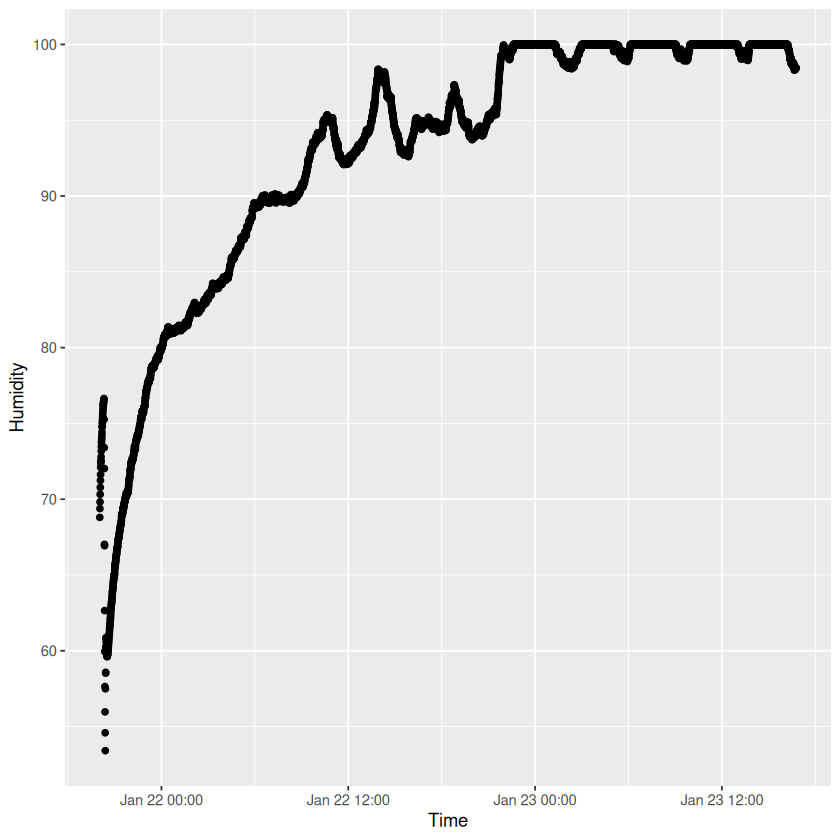

In [17]:
#retain rows from data set that are "raw" (average values are inaccurate and skew data), then convert time and RH to numeric
ch4_1_d_raw<-subset(as.data.frame(ch4_1_d),type=="raw")

ch4_1_d_raw$dtp<-lubridate::as_datetime(as.integer(ch4_1_d_raw$time.s))

#display time plot of humidity
ggplot(ch4_1_d_raw,aes(dtp,as.numeric(aht_RH)))+
    xlab("Time")+ylab("Humidity")+
    geom_point()

Next we want to generate a plot showing the raw sensor values over time. 

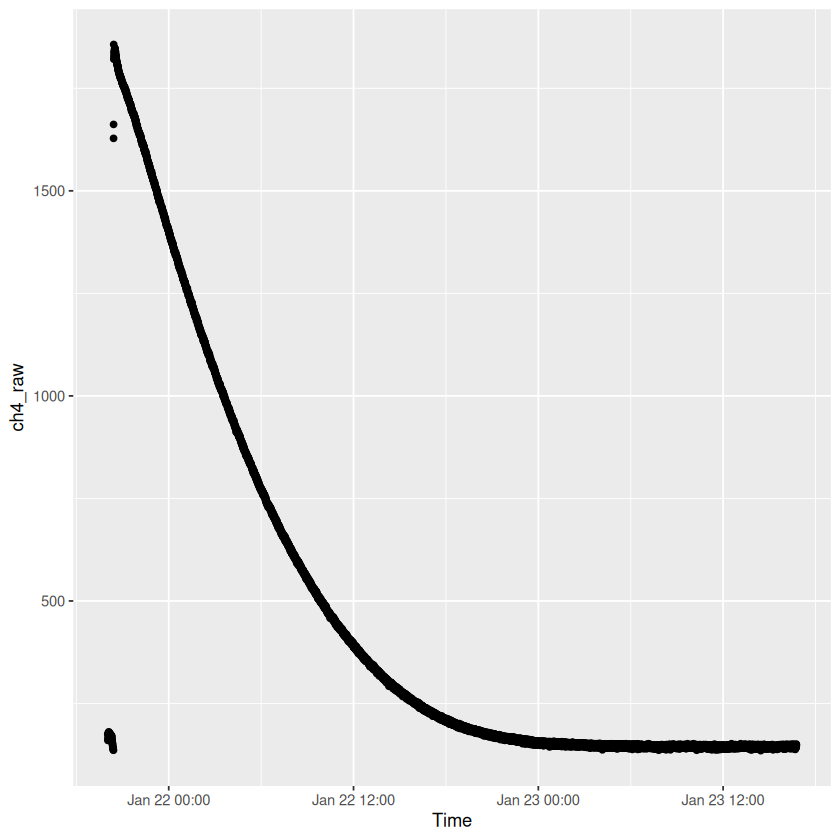

In [19]:
#create time plot of raw sensor values
ggplot(ch4_1_d_raw,aes(dtp,as.numeric(ch4_raw)))+
    xlab("Time")+ylab("ch4_raw")+
    geom_point()

Since we created a new dataframe, we need to run another approximation. We will use the same code as before, except add an approximation for the gas temperature from the ABB portable gas analyzer for further analysis.

In [20]:
ch4_1_d_raw$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_1_d_raw$dtp)$y
ch4_1_d_raw$temp_c_abb<-approx(abb_clean$dtp,abb_clean$temp_c_abb,xout=ch4_1_d_raw$dtp)$y

At this point, all we need to do is clean our data by removing unwanted (in this case, NA) values, ensure numeric class types, and filter out the correct time series we would like to have for our dataframe. The code below walks us through these modifications. To avoid confusion, note that we use the subset() function in the first line of code to transform our desired data into another new dataframe called ch4_#_d_keep.

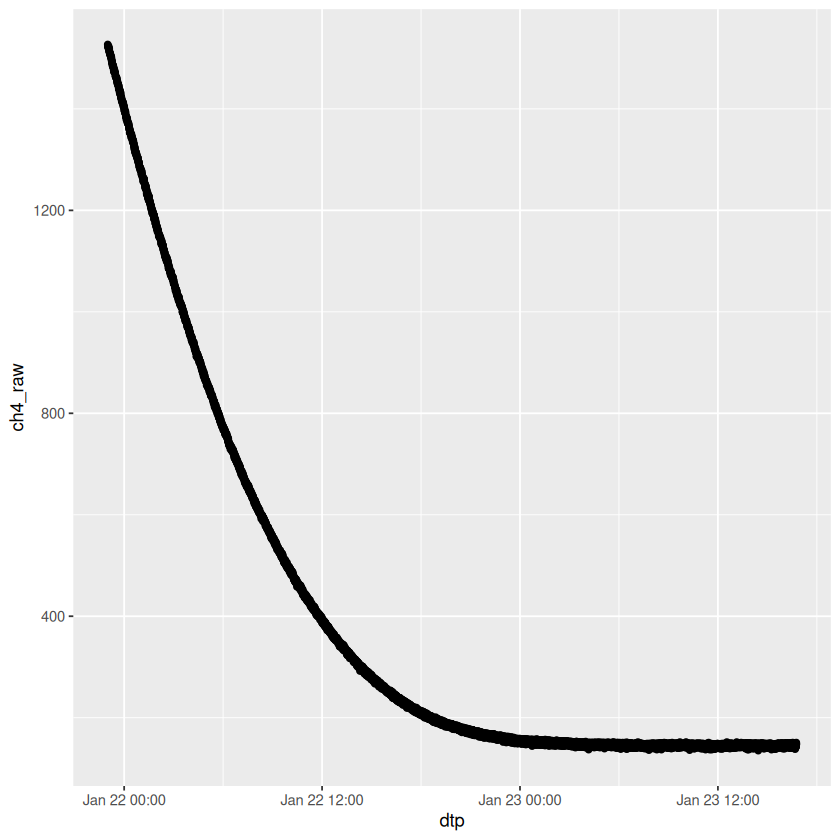

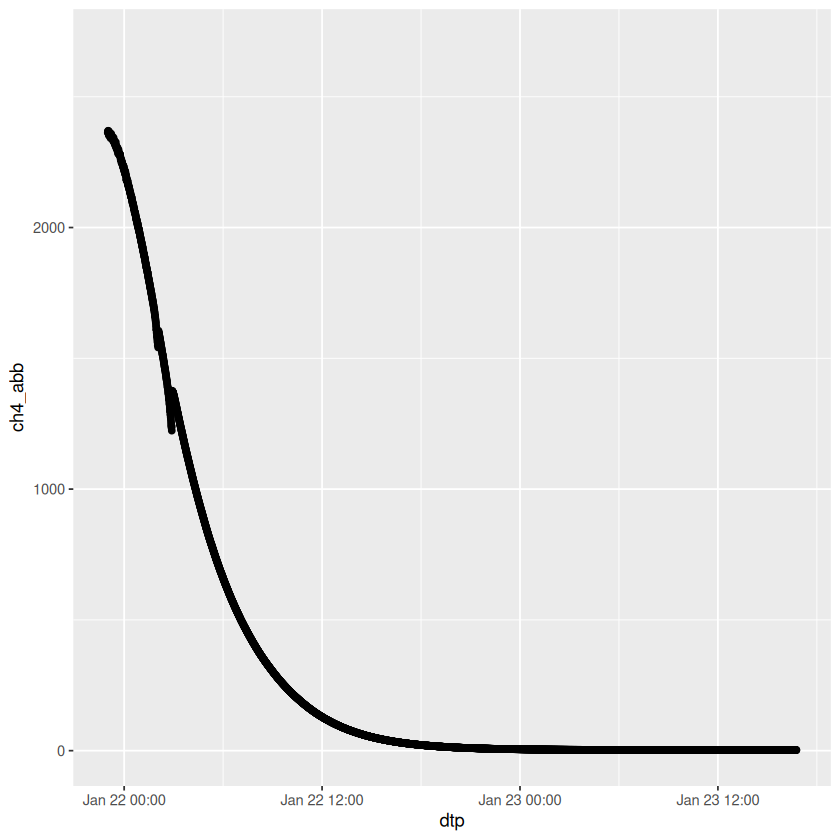

In [21]:
#prepping data for model (removing NA values, setting 3 variables to numerical instead of character)
ch4_1_d_keep<-subset(ch4_1_d_raw,!is.na(aht_RH) & !is.na(aht_C) & !is.na(ch4_raw) & !is.na(ch4_abb))
ch4_1_d_keep$aht_C<-as.numeric(ch4_1_d_keep$aht_C)
ch4_1_d_keep$aht_RH<-as.numeric(ch4_1_d_keep$aht_RH)
ch4_1_d_keep$ch4_raw<-as.numeric(ch4_1_d_keep$ch4_raw)

#removing any negative values from the ch4_abb column and setting our time interval to match the ABB reference data
ch4_1_d_keep <- ch4_1_d_keep[ch4_1_d_keep$ch4_abb >=0, ]
ch4_1_d_keep <- ch4_1_d_keep[ch4_1_d_keep$dtp >= "2025-01-21 18:00:00", ]

#visualize ch4_raw and ch4_abb on time series
ggplot()+geom_point(data=ch4_1_d_keep,aes(x=dtp,y=ch4_raw))
ggplot()+geom_point(data=ch4_1_d_keep,aes(x=dtp,y=ch4_abb))+ylim(0,2700)

Using the new dataframe with filtered data above, we can see how much cleaner our time series plot appear, indicating we successfully cleaned our data.

The next step is to run the GAM, which is actually only one line of code (gam() is part of the mgcv package). We can modify the parameters of the model by adjusting the k values, which are the knots. Adjusting these values will determine goodness of fit for our model. Higher k values will result in overfitting, while lower k values will result in underfitting and potentially missing the relationship. Feel free to practice using this model by changing the k values for each variable and observing the varying results.

In [23]:
#create gam (adjust k values to get tighter fits and higher R-squ)
ch4_cal_gam_1<- gam(ch4_abb~ s(ch4_raw,k = 20)+s(aht_C,k = 20)+s(aht_RH,k=20), drop.intercept = FALSE, data=ch4_1_d_keep)

#viewing gam results
summary(ch4_cal_gam_1)


Family: gaussian 
Link function: identity 

Formula:
ch4_abb ~ s(ch4_raw, k = 20) + s(aht_C, k = 20) + s(aht_RH, k = 20)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 312.00545    0.09032    3455   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df      F p-value    
s(ch4_raw) 18.80  18.99 788.04  <2e-16 ***
s(aht_C)   18.90  19.00  24.39  <2e-16 ***
s(aht_RH)  18.94  19.00  34.10  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =      1   Deviance explained =  100%
GCV = 45.414  Scale est. = 44.938    n = 5509

Using our generalized additive model above, we are going to start predicting methane values. The code below will walk us through how to set up the value prediction process, as well as create a 3D model to visually assess if our predicted values are accurate. We can adjust the theta and phi values in the 3D model code in order to change the persepctive of the display.

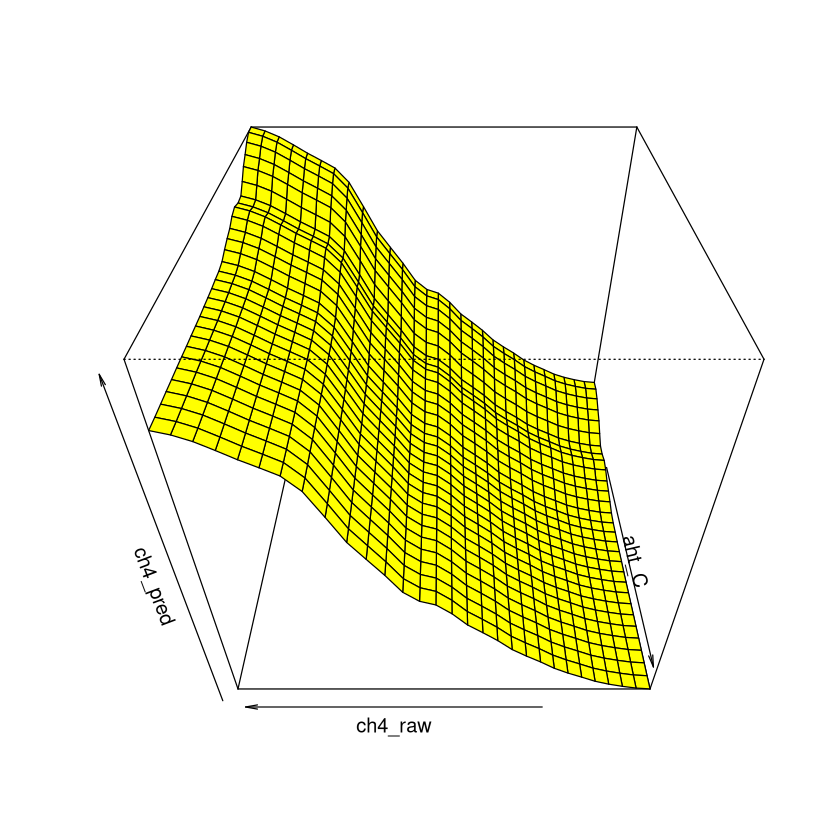

In [26]:
#generating prediction data by creating grid values (30 random points) in each column from min to max then combines them into
#a dataframe using the expand.grid() function (humidity will remain a constant).
steps <- 30
ch4_raw <- with(ch4_1_d_keep, seq(min(ch4_raw), max(ch4_raw), length = steps))
aht_RH <- with(ch4_1_d_keep, seq(min(aht_RH), max(aht_RH), length = steps))
aht_C <- with(ch4_1_d_keep, seq(min(aht_C), max(aht_C), length = steps))
newdat <- expand.grid(ch4_raw = ch4_raw, aht_C = aht_C, aht_RH = 100)

#using the predict() function to make predictions for the newdat dataset based off of the GAM dataset, then convert result
#into a matrix that is 30x30 (steps x steps) in an object titles ch4_pred.
ch4_pred <- matrix(predict(ch4_cal_gam_1, newdat), steps, steps)

#creating a 3D plot showing the relationship between temperature, raw sensor values, and predicted values.
p <- persp(ch4_raw,aht_C,ch4_pred, theta = 180, phi =40, col = "yellow")

We now wish to add a new column to our dataframe that will be our predicted values based on our model. Then we will generate a plot with the true values along with the predicted values overlaying the true values in blue to visually assess how accurate our model predictions are.

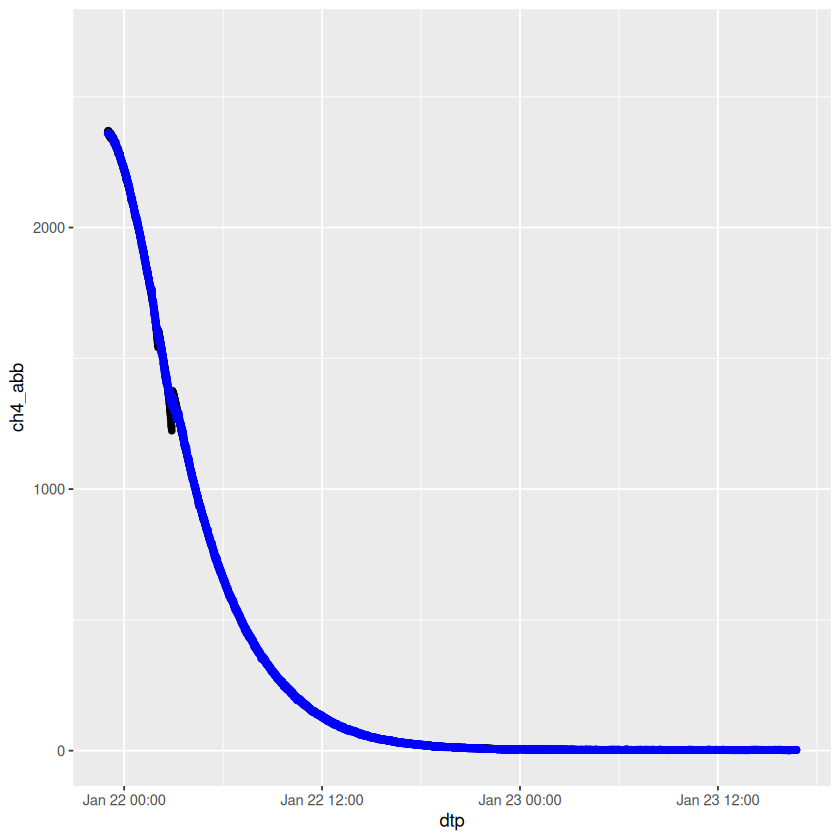

In [27]:
#creates new column in original dataframe titled ch4_predicted to generate predicted data points based on our GAM.
ch4_1_d_keep$ch4_predicted<-predict(ch4_cal_gam_1,ch4_1_d_keep)

#overlay CH4_abb scatter plot with predicted values (blue).
ggplot()+
geom_point(data=ch4_1_d_keep,aes(x=dtp,y=ch4_abb))+
geom_point(data=ch4_1_d_keep,aes(x=dtp,y=ch4_predicted),color="blue")+ylim(0,2700)

Success! Our model predictions appear to be quite accurate, indicating our calibration model is working! Now we must repeat the same process above for the remaining three sensors. We can run the code in larger blocks, though, to speed up the workflow. However, it is still advantageous to appropriate unrelated code into different cells in order to aid in debugging if you are ever met with any errors.

### Sensor ch4_2

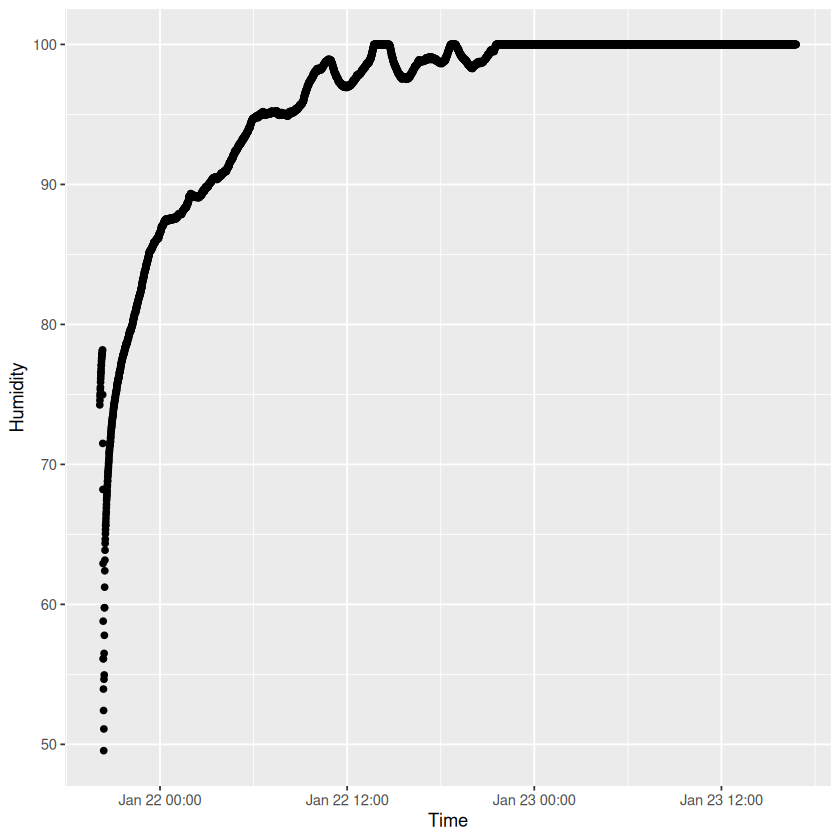

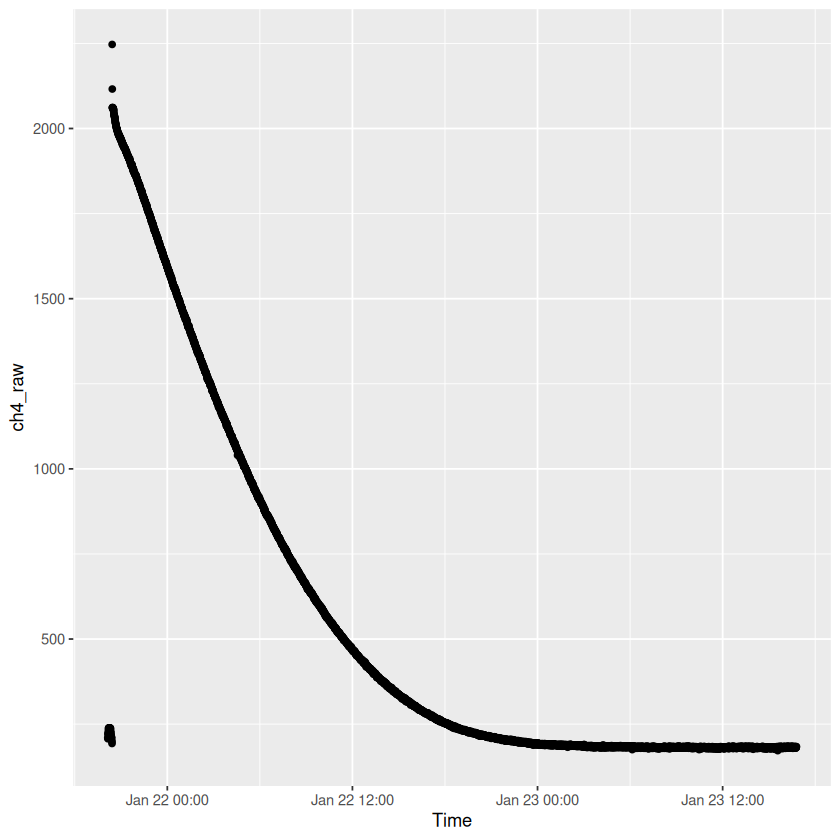

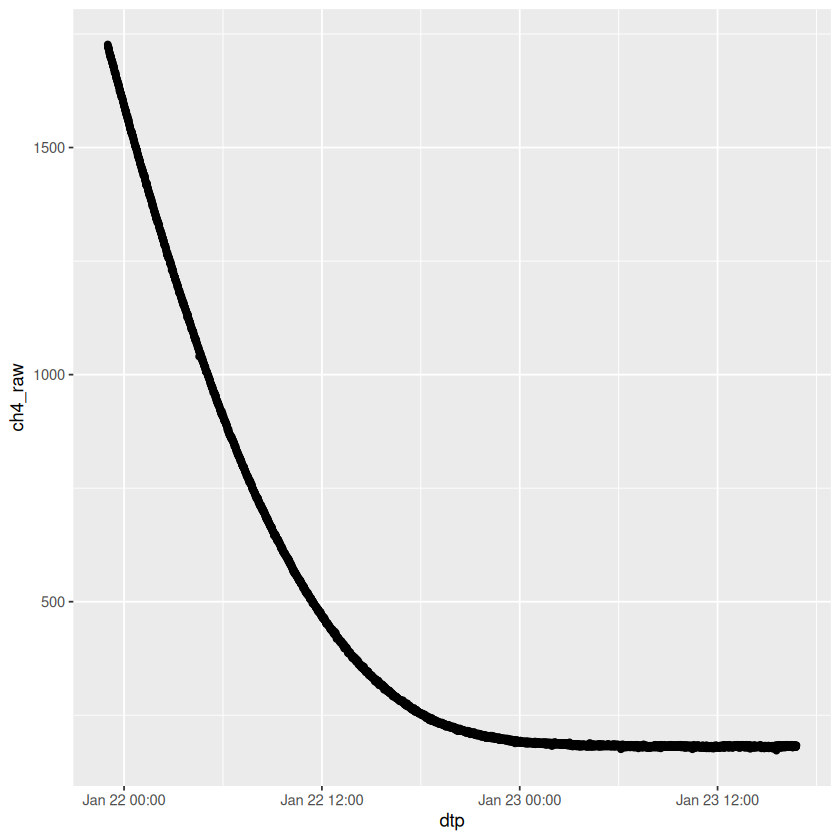

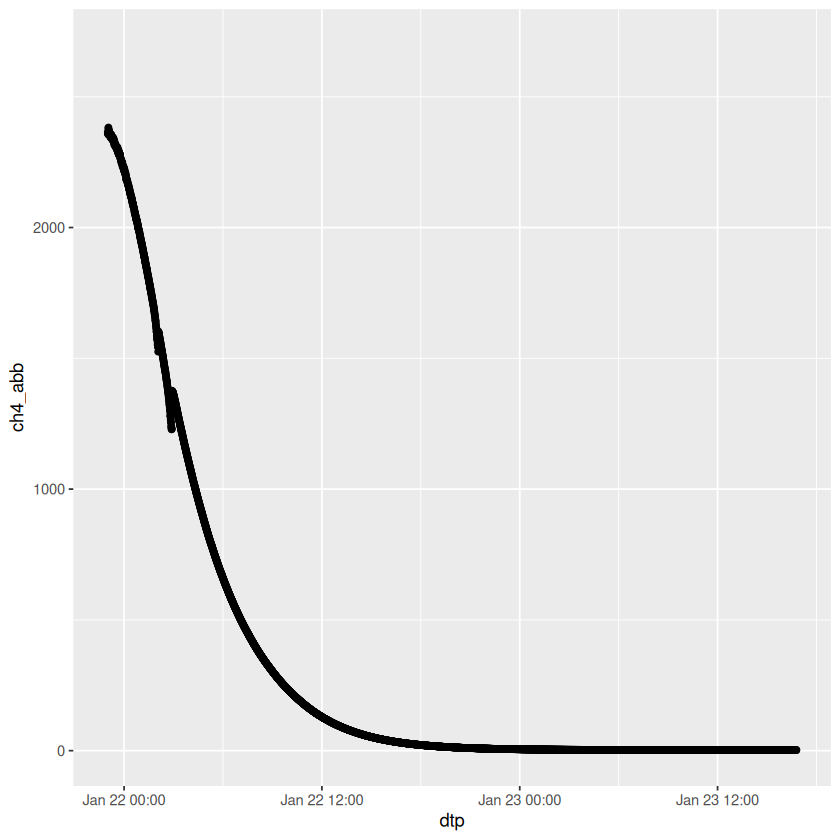

In [29]:
#retain rows from data set that are "raw" (average values are inaccurate and skew data), then convert time and RH to numeric
ch4_2_d_raw<-subset(as.data.frame(ch4_2_d),type=="raw")

ch4_2_d_raw$dtp<-lubridate::as_datetime(as.integer(ch4_2_d_raw$time.s))

ggplot(ch4_2_d_raw,aes(dtp,as.numeric(aht_RH)))+
    xlab("Time")+ylab("Humidity")+
    geom_point()

ggplot(ch4_2_d_raw,aes(dtp,as.numeric(ch4_raw)))+
    xlab("Time")+ylab("ch4_raw")+
    geom_point()

ch4_2_d_raw$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_2_d_raw$dtp)$y
ch4_2_d_raw$temp_c_abb<-approx(abb_clean$dtp,abb_clean$temp_c_abb,xout=ch4_2_d_raw$dtp)$y

#prepping data for model (removing NA values, setting 3 variables to numerical instead of character)
ch4_2_d_keep<-subset(ch4_2_d_raw,!is.na(aht_RH) & !is.na(aht_C) & !is.na(ch4_raw) & !is.na(ch4_abb))
ch4_2_d_keep$aht_C<-as.numeric(ch4_2_d_keep$aht_C)
ch4_2_d_keep$aht_RH<-as.numeric(ch4_2_d_keep$aht_RH)
ch4_2_d_keep$ch4_raw<-as.numeric(ch4_2_d_keep$ch4_raw)
#removing the random negative value from the abb column
ch4_2_d_keep <- ch4_2_d_keep[ch4_2_d_keep$ch4_abb >=0, ]
ch4_2_d_keep <- ch4_2_d_keep[ch4_2_d_keep$dtp >= "2025-01-21 18:00:00", ]

#visualize ch4_raw and ch4_abb on time series (also change time limits to get rid of early outliers)
ggplot()+geom_point(data=ch4_2_d_keep,aes(x=dtp,y=ch4_raw))
ggplot()+geom_point(data=ch4_2_d_keep,aes(x=dtp,y=ch4_abb))+ylim(0,2700)

In [30]:
#create gam (adjust k values to get tighter fits and higher R-squ)
ch4_cal_gam_2<- gam(ch4_abb~ s(ch4_raw,k = 20)+s(aht_C,k = 20)+s(aht_RH,k=20), drop.intercept = FALSE, data=ch4_2_d_keep)

#viewing gam results
summary(ch4_cal_gam_2)


Family: gaussian 
Link function: identity 

Formula:
ch4_abb ~ s(ch4_raw, k = 20) + s(aht_C, k = 20) + s(aht_RH, k = 20)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 311.84452    0.09004    3464   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df      F p-value    
s(ch4_raw) 18.90     19 327.36  <2e-16 ***
s(aht_C)   18.94     19  25.43  <2e-16 ***
s(aht_RH)  18.94     19  25.97  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =      1   Deviance explained =  100%
GCV = 45.157  Scale est. = 44.684    n = 5512

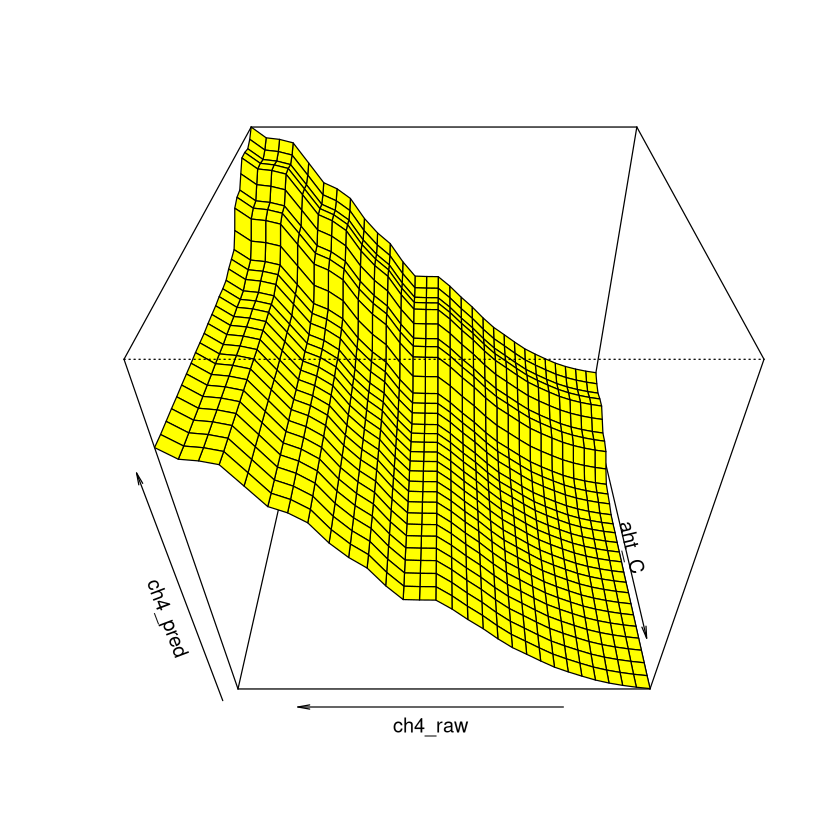

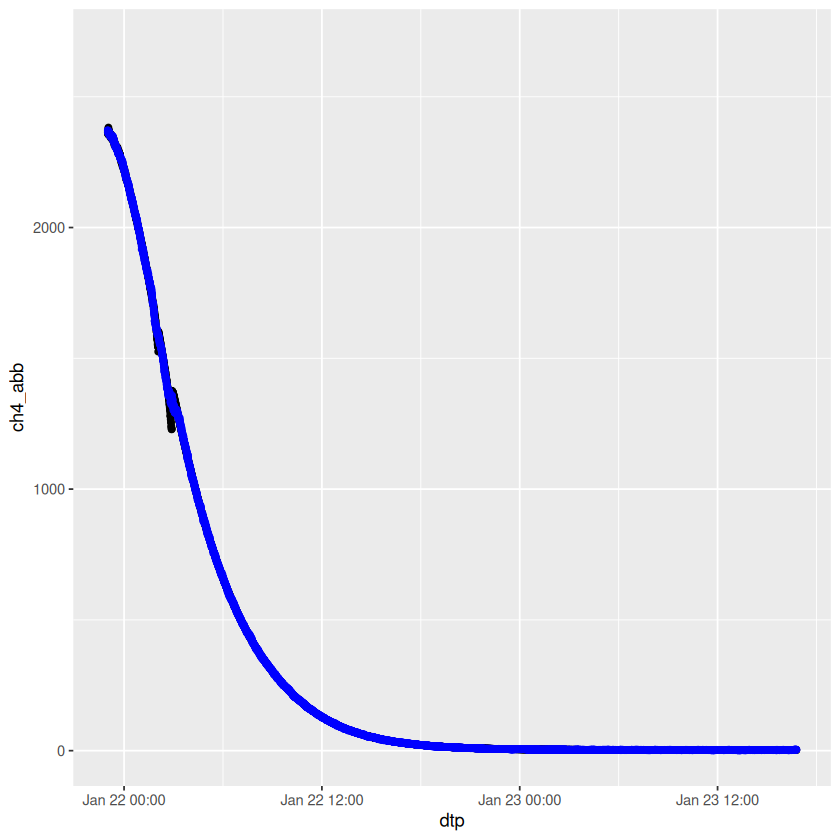

In [31]:
#generating prediction data by creating grid values (30 points) in each column from min to max then combines them into
#a data frame using the expand.grid() function
steps <- 30
ch4_raw <- with(ch4_2_d_keep, seq(min(ch4_raw), max(ch4_raw), length = steps))
aht_RH <- with(ch4_2_d_keep, seq(min(aht_RH), max(aht_RH), length = steps))
aht_C <- with(ch4_2_d_keep, seq(min(aht_C), max(aht_C), length = steps))
newdat <- expand.grid(ch4_raw = ch4_raw, aht_C = aht_C, aht_RH = 100)
#using the predict() function to make predictions for the newdat dataset based off of the GAM dataset, then convert result
#into a matrix that is 30x30 (steps x steps)
ch4_pred <- matrix(predict(ch4_cal_gam_2, newdat), steps, steps)

#creating a 3D plot showing the relationship between these 3 variables
p <- persp(ch4_raw,aht_C,ch4_pred, theta = 180, phi =40, col = "yellow")

#creates new column in original data frame titled ch4_predicted to generate predicted data points based on GAM results
ch4_2_d_keep$ch4_predicted<-predict(ch4_cal_gam_2,ch4_2_d_keep)

#overlay CH4_abb scatter plot with predicted values (blue)
ggplot()+
geom_point(data=ch4_2_d_keep,aes(x=dtp,y=ch4_abb))+
geom_point(data=ch4_2_d_keep,aes(x=dtp,y=ch4_predicted),color="blue")+ylim(0,2700)

### Sensor ch4_3

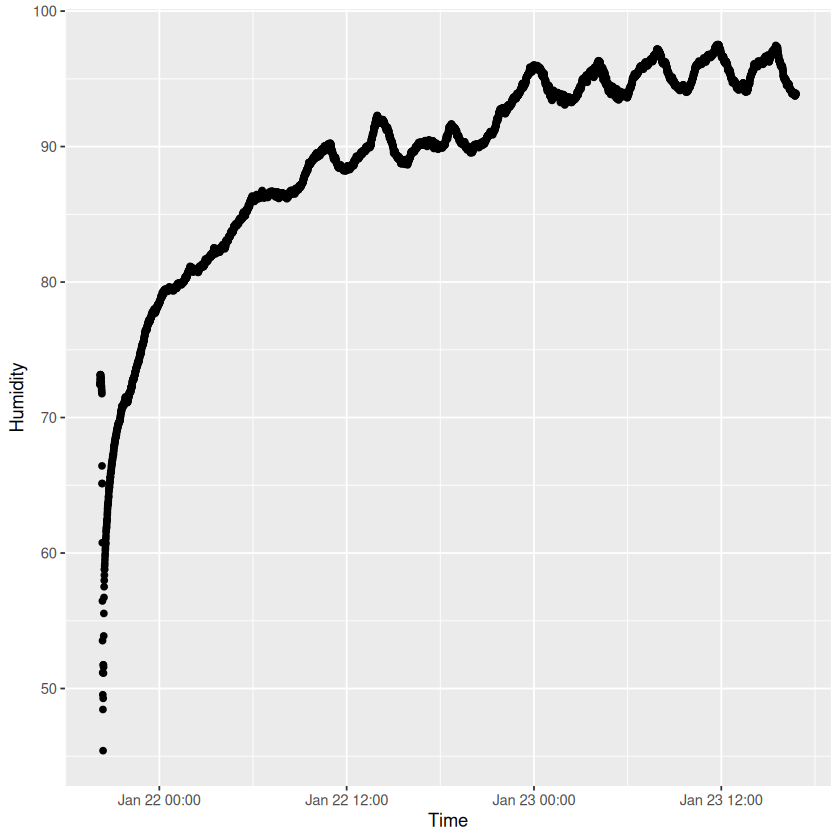

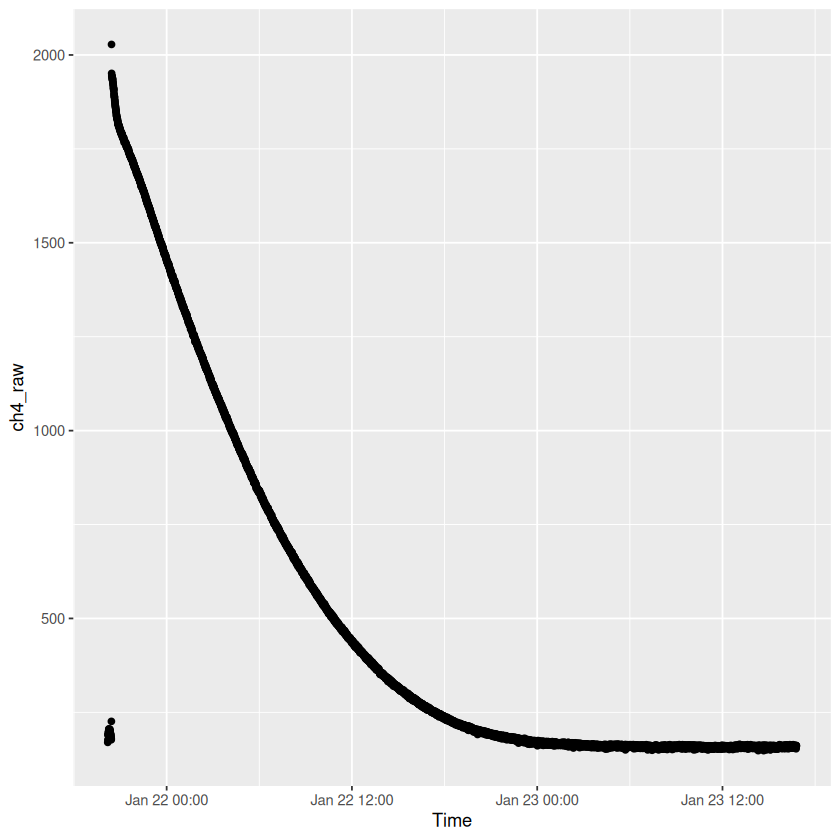

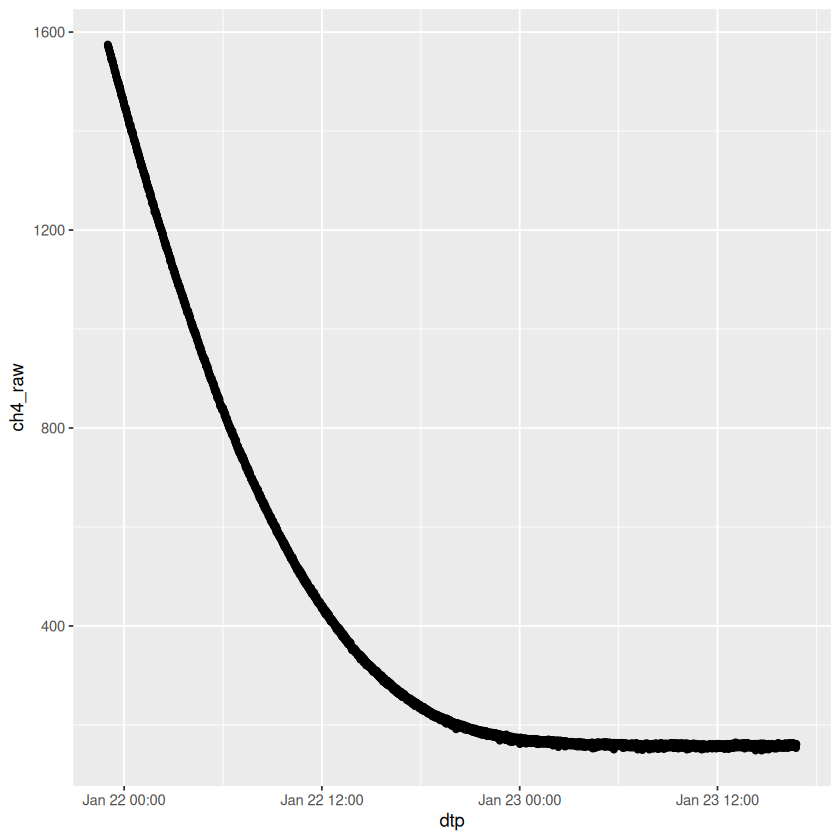

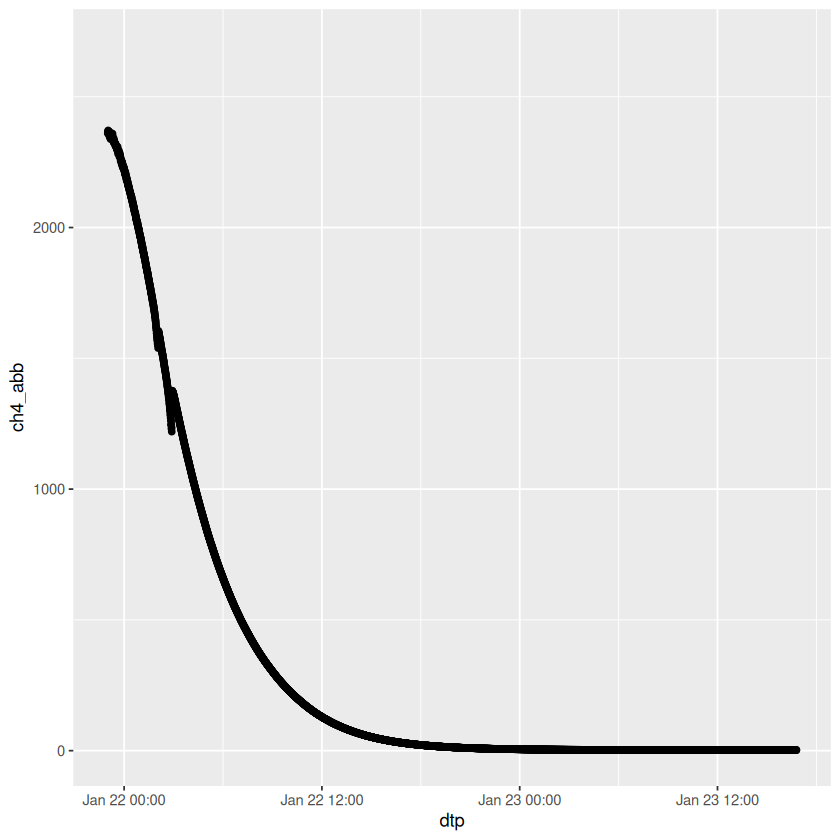

In [32]:
#retain rows from data set that are "raw" (average values are inaccurate and skew data), then convert time and RH to numeric
ch4_3_d_raw<-subset(as.data.frame(ch4_3_d),type=="raw")

ch4_3_d_raw$dtp<-lubridate::as_datetime(as.integer(ch4_3_d_raw$time.s))

ggplot(ch4_3_d_raw,aes(dtp,as.numeric(aht_RH)))+
    xlab("Time")+ylab("Humidity")+
    geom_point()

ggplot(ch4_3_d_raw,aes(dtp,as.numeric(ch4_raw)))+
    xlab("Time")+ylab("ch4_raw")+
    geom_point()


ch4_3_d_raw$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_3_d_raw$dtp)$y
ch4_3_d_raw$temp_c_abb<-approx(abb_clean$dtp,abb_clean$temp_c_abb,xout=ch4_3_d_raw$dtp)$y

#prepping data for model (removing NA values, setting 3 variables to numerical instead of character)
ch4_3_d_keep<-subset(ch4_3_d_raw,!is.na(aht_RH) & !is.na(aht_C) & !is.na(ch4_raw) & !is.na(ch4_abb))
ch4_3_d_keep$aht_C<-as.numeric(ch4_3_d_keep$aht_C)
ch4_3_d_keep$aht_RH<-as.numeric(ch4_3_d_keep$aht_RH)
ch4_3_d_keep$ch4_raw<-as.numeric(ch4_3_d_keep$ch4_raw)
#removing the random negative value from the abb column
ch4_3_d_keep <- ch4_3_d_keep[ch4_3_d_keep$ch4_abb >=0, ]
ch4_3_d_keep <- ch4_3_d_keep[ch4_3_d_keep$dtp >= "2025-01-21 18:00:00", ]

#visualize ch4_raw and ch4_abb on time series (also change time limits to get rid of early outliers)
ggplot()+geom_point(data=ch4_3_d_keep,aes(x=dtp,y=ch4_raw))
ggplot()+geom_point(data=ch4_3_d_keep,aes(x=dtp,y=ch4_abb))+ylim(0,2700)

In [35]:
#create gam (adjust k values to get tighter fits and higher R-squ)
ch4_cal_gam_3<- gam(ch4_abb~ s(ch4_raw,k = 20)+s(aht_C,k = 20)+s(aht_RH,k=20), drop.intercept = FALSE, data=ch4_3_d_keep)

#viewing gam results
summary(ch4_cal_gam_3)


Family: gaussian 
Link function: identity 

Formula:
ch4_abb ~ s(ch4_raw, k = 20) + s(aht_C, k = 20) + s(aht_RH, k = 20)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 311.73987    0.09614    3243   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df         F p-value    
s(ch4_raw) 18.86     19 10084.924  <2e-16 ***
s(aht_C)    1.00      1     3.829  0.0504 .  
s(aht_RH)  18.96     19    26.895  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =      1   Deviance explained =  100%
GCV = 51.325  Scale est. = 50.954    n = 5513

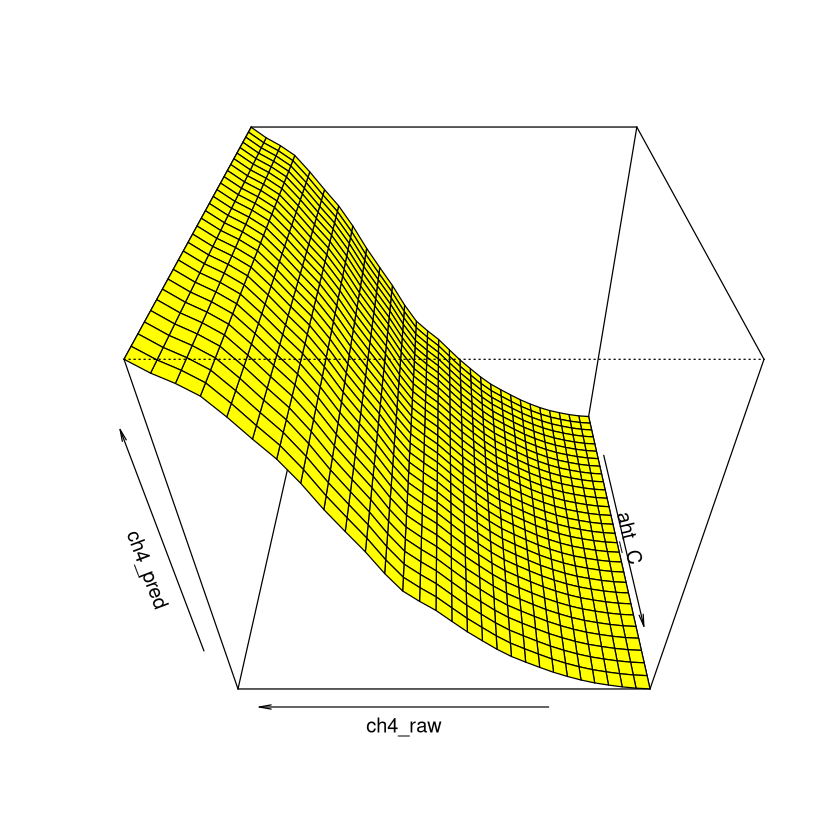

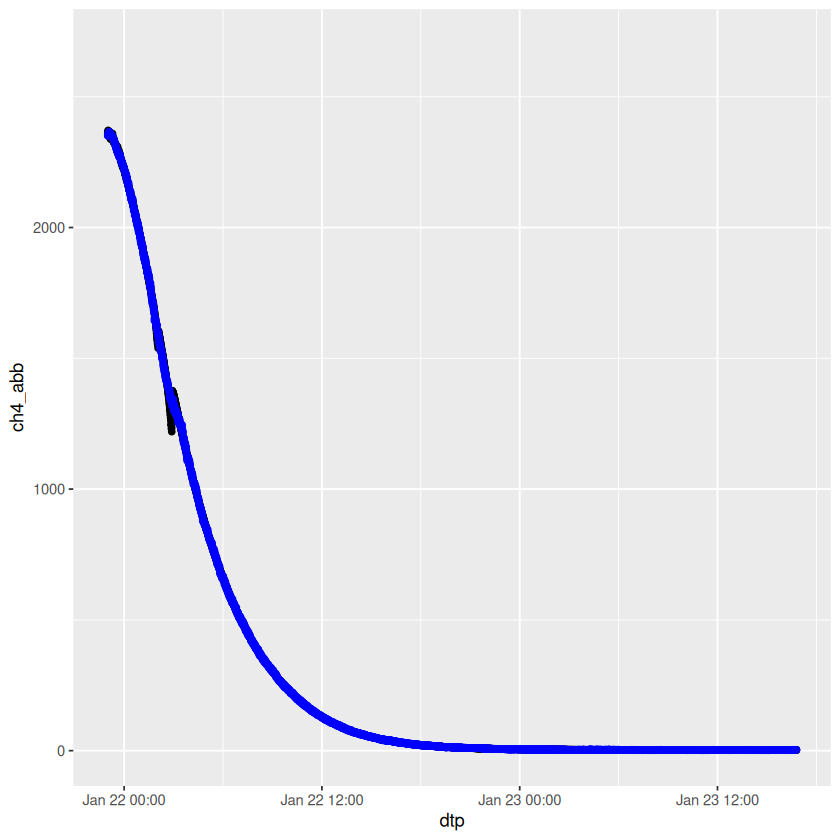

In [36]:
#generating prediction data by creating grid values (30 points) in each column from min to max then combines them into
#a data frame using the expand.grid() function
steps <- 30
ch4_raw <- with(ch4_3_d_keep, seq(min(ch4_raw), max(ch4_raw), length = steps))
aht_RH <- with(ch4_3_d_keep, seq(min(aht_RH), max(aht_RH), length = steps))
aht_C <- with(ch4_3_d_keep, seq(min(aht_C), max(aht_C), length = steps))
newdat <- expand.grid(ch4_raw = ch4_raw, aht_C = aht_C, aht_RH = 100)
#using the predict() function to make predictions for the newdat dataset based off of the GAM dataset, then convert result
#into a matrix that is 30x30 (steps x steps)
ch4_pred <- matrix(predict(ch4_cal_gam_3, newdat), steps, steps)

#creating a 3D plot showing the relationship between these 3 variables
p <- persp(ch4_raw,aht_C,ch4_pred, theta = 180, phi =40, col = "yellow")

#creates new column in original data frame titled ch4_predicted to generate predicted data points based on GAM results
ch4_3_d_keep$ch4_predicted<-predict(ch4_cal_gam_3,ch4_3_d_keep)

#overlay CH4_abb scatter plot with predicted values (blue)
ggplot()+
geom_point(data=ch4_3_d_keep,aes(x=dtp,y=ch4_abb))+
geom_point(data=ch4_3_d_keep,aes(x=dtp,y=ch4_predicted),color="blue")+ylim(0,2700)

### Sensor ch4_4

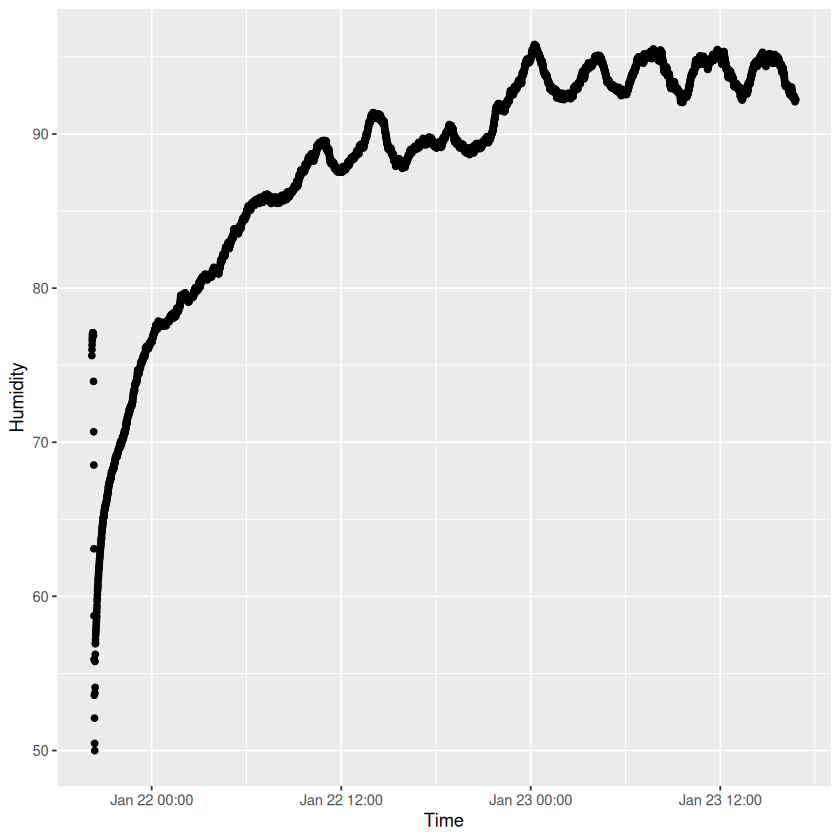

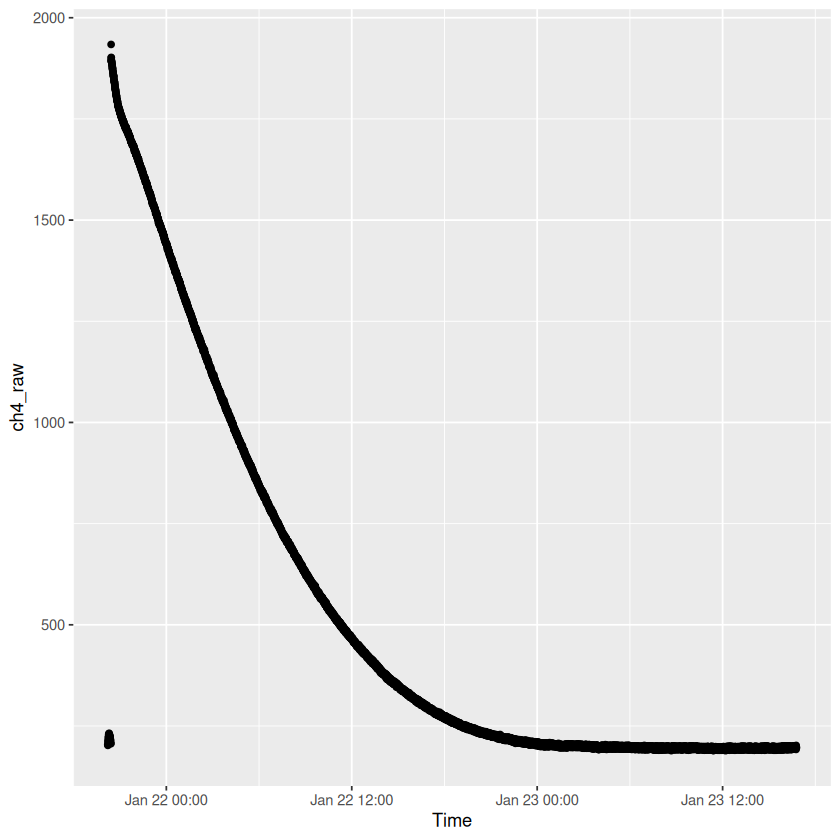

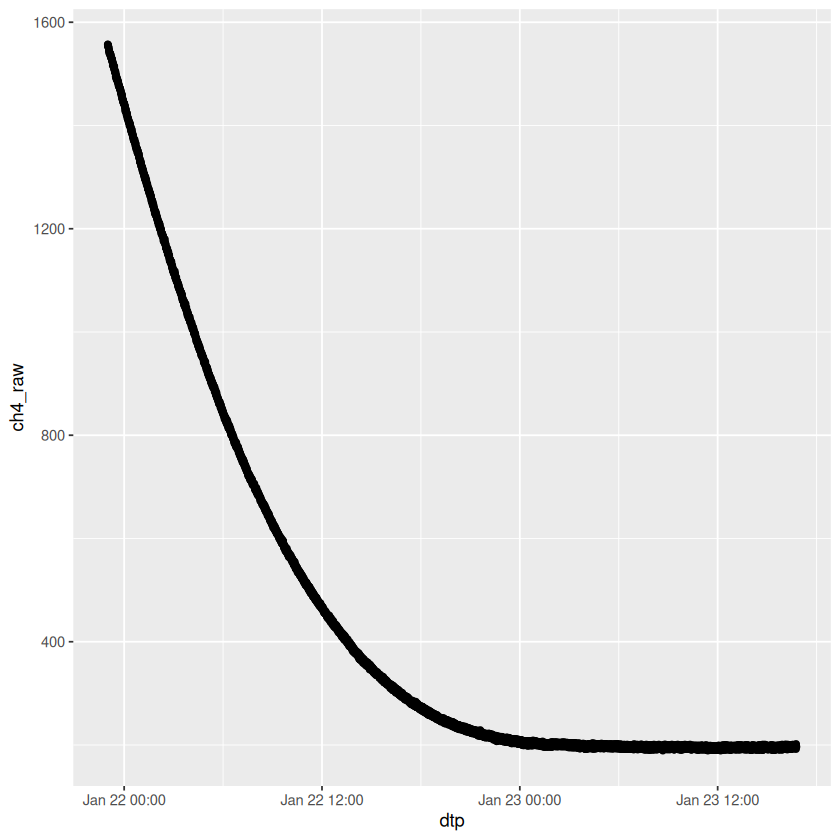

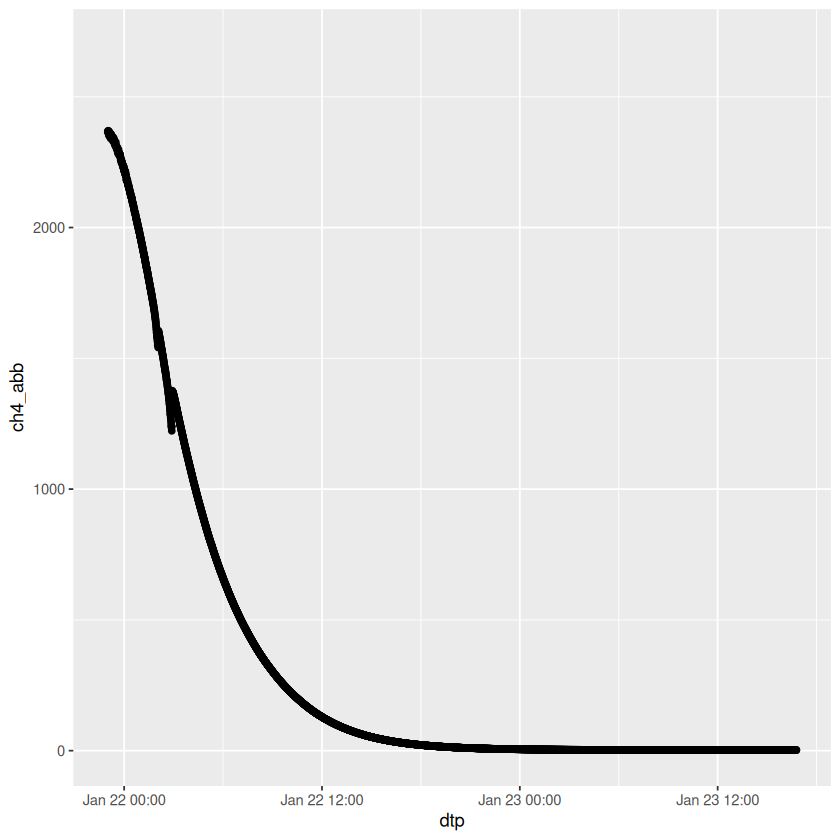

In [37]:
#retain rows from data set that are "raw" (average values are inaccurate and skew data), then convert time and RH to numeric
ch4_4_d_raw<-subset(as.data.frame(ch4_4_d),type=="raw")

ch4_4_d_raw$dtp<-lubridate::as_datetime(as.integer(ch4_4_d_raw$time.s))

ggplot(ch4_4_d_raw,aes(dtp,as.numeric(aht_RH)))+
    xlab("Time")+ylab("Humidity")+
    geom_point()

ggplot(ch4_4_d_raw,aes(dtp,as.numeric(ch4_raw)))+
    xlab("Time")+ylab("ch4_raw")+
    geom_point()


ch4_4_d_raw$ch4_abb<-approx(abb_clean$dtp,abb_clean$ch4_abb,xout=ch4_4_d_raw$dtp)$y
ch4_4_d_raw$temp_c_abb<-approx(abb_clean$dtp,abb_clean$temp_c_abb,xout=ch4_4_d_raw$dtp)$y

#prepping data for model (removing NA values, setting 3 variables to numerical instead of character)
ch4_4_d_keep<-subset(ch4_4_d_raw,!is.na(aht_RH) & !is.na(aht_C) & !is.na(ch4_raw) & !is.na(ch4_abb))
ch4_4_d_keep$aht_C<-as.numeric(ch4_4_d_keep$aht_C)
ch4_4_d_keep$aht_RH<-as.numeric(ch4_4_d_keep$aht_RH)
ch4_4_d_keep$ch4_raw<-as.numeric(ch4_4_d_keep$ch4_raw)
#removing the random negative value from the abb column
ch4_4_d_keep <- ch4_4_d_keep[ch4_4_d_keep$ch4_abb >=0, ]
ch4_4_d_keep <- ch4_4_d_keep[ch4_4_d_keep$dtp >= "2025-01-21 18:00:00", ]

#visualize ch4_raw and ch4_abb on time series (also change time limits to get rid of early outliers)
ggplot()+geom_point(data=ch4_4_d_keep,aes(x=dtp,y=ch4_raw))
ggplot()+geom_point(data=ch4_4_d_keep,aes(x=dtp,y=ch4_abb))+ylim(0,2700)

In [38]:
#create gam (adjust k values to get tighter fits and higher R-squ)
ch4_cal_gam_4<- gam(ch4_abb~ s(ch4_raw,k = 20)+s(aht_C,k = 20)+s(aht_RH,k=20), drop.intercept = FALSE, data=ch4_4_d_keep)

#viewing gam results
summary(ch4_cal_gam_4)


Family: gaussian 
Link function: identity 

Formula:
ch4_abb ~ s(ch4_raw, k = 20) + s(aht_C, k = 20) + s(aht_RH, k = 20)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 312.16570    0.09349    3339   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df      F p-value    
s(ch4_raw) 18.90  18.99 391.23  <2e-16 ***
s(aht_C)   18.86  18.99  27.53  <2e-16 ***
s(aht_RH)  18.63  18.97  17.32  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =      1   Deviance explained =  100%
GCV = 48.683  Scale est. = 48.176    n = 5512

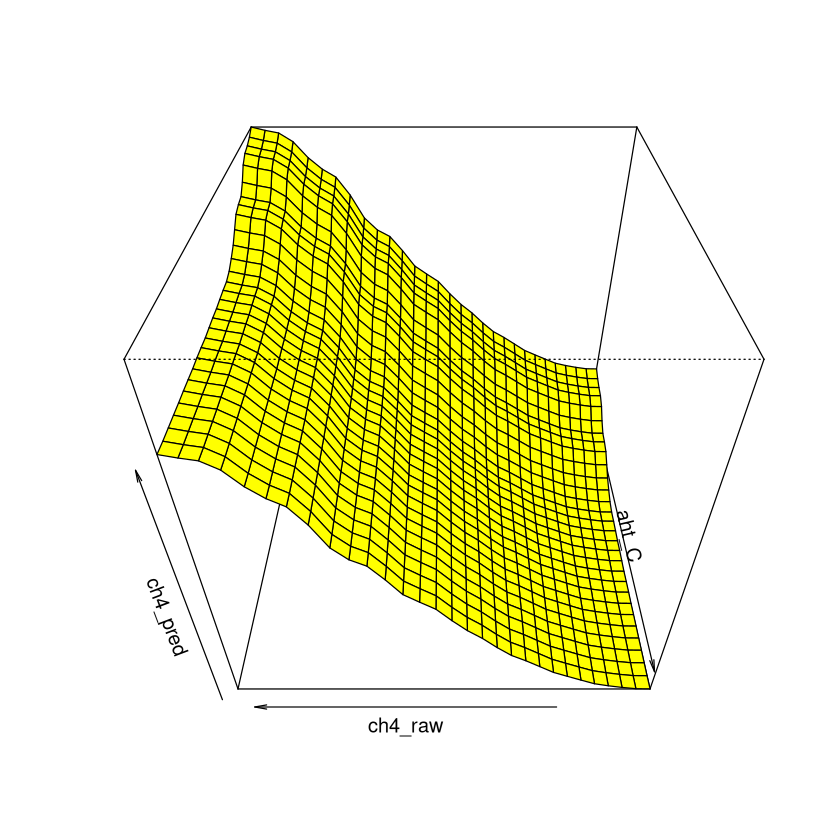

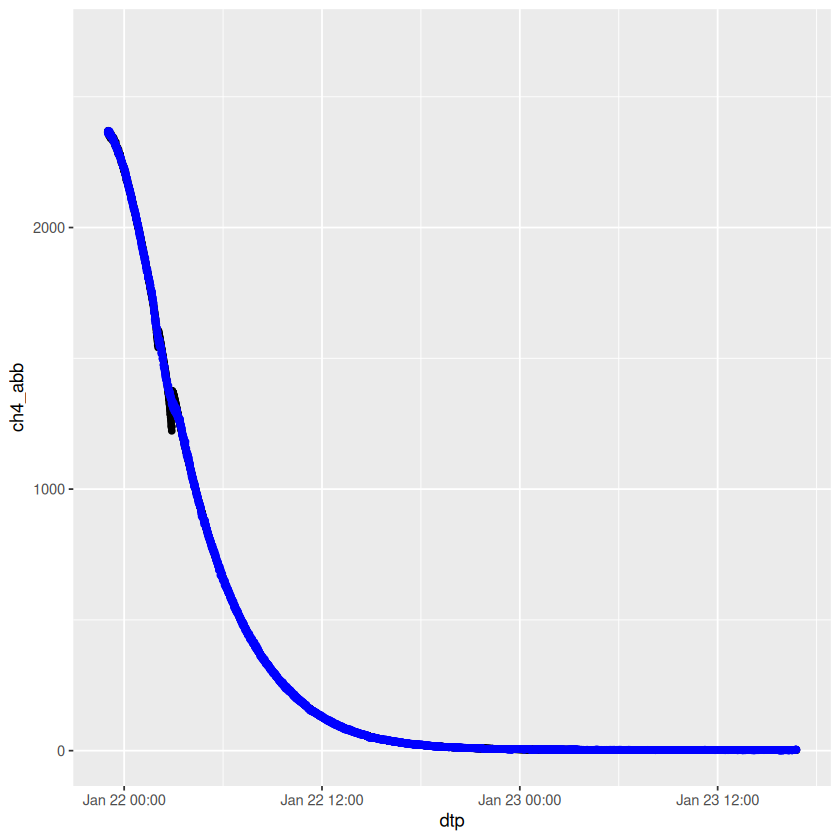

In [39]:
#generating prediction data by creating grid values (30 points) in each column from min to max then combines them into
#a data frame using the expand.grid() function
steps <- 30
ch4_raw <- with(ch4_4_d_keep, seq(min(ch4_raw), max(ch4_raw), length = steps))
aht_RH <- with(ch4_4_d_keep, seq(min(aht_RH), max(aht_RH), length = steps))
aht_C <- with(ch4_4_d_keep, seq(min(aht_C), max(aht_C), length = steps))
newdat <- expand.grid(ch4_raw = ch4_raw, aht_C = aht_C, aht_RH = 100)
#using the predict() function to make predictions for the newdat dataset based off of the GAM dataset, then convert result
#into a matrix that is 30x30 (steps x steps)
ch4_pred <- matrix(predict(ch4_cal_gam_4, newdat), steps, steps)

#creating a 3D plot showing the relationship between these 3 variables
p <- persp(ch4_raw,aht_C,ch4_pred, theta = 180, phi =40, col = "yellow")

#creates new column in original data frame titled ch4_predicted to generate predicted data points based on GAM results
ch4_4_d_keep$ch4_predicted<-predict(ch4_cal_gam_4,ch4_4_d_keep)

#overlay CH4_abb scatter plot with predicted values (blue)
ggplot()+
geom_point(data=ch4_4_d_keep,aes(x=dtp,y=ch4_abb))+
geom_point(data=ch4_4_d_keep,aes(x=dtp,y=ch4_predicted),color="blue")+ylim(0,2700)

### Combined Sensor Model

We have created individual models for each unique sensor, but in order to work towards the goal of creating a universal model for calibration, we must create a combined model with data from all the sensors. We start off by classifying the data into the classes we need them to be in. We also add a column to each dataframe titled "ch4_sensor" in order to have an identifier if we ever need to separate the combined dataframe by sensor type. We then use the bind_rows() function to combine all our data into a single dataframe we will call ch4_comb. 

In [56]:
ch4_1_d_keep$aht_C <- as.numeric(ch4_1_d_keep$aht_C)
ch4_2_d_keep$aht_C <- as.numeric(ch4_2_d_keep$aht_C)
ch4_3_d_keep$aht_C <- as.numeric(ch4_3_d_keep$aht_C)
ch4_4_d_keep$aht_C <- as.numeric(ch4_4_d_keep$aht_C)

ch4_1_d_keep$ch4_raw <- as.numeric(ch4_1_d_keep$ch4_raw)
ch4_2_d_keep$ch4_raw <- as.numeric(ch4_2_d_keep$ch4_raw)
ch4_3_d_keep$ch4_raw <- as.numeric(ch4_3_d_keep$ch4_raw)
ch4_4_d_keep$ch4_raw <- as.numeric(ch4_4_d_keep$ch4_raw)

ch4_1_d_keep$aht_RH <- as.numeric(ch4_1_d_keep$aht_RH)
ch4_2_d_keep$aht_RH <- as.numeric(ch4_2_d_keep$aht_RH)
ch4_3_d_keep$aht_RH <- as.numeric(ch4_3_d_keep$aht_RH)
ch4_4_d_keep$aht_RH <- as.numeric(ch4_4_d_keep$aht_RH)

ch4_1_d_keep$ch4_sensor <- as.factor("1.1")
ch4_2_d_keep$ch4_sensor <- as.factor("1.2")
ch4_3_d_keep$ch4_sensor <- as.factor("1.3")
ch4_4_d_keep$ch4_sensor <- as.factor("1.4")

ch4_comb <- bind_rows(ch4_1_d_keep,ch4_2_d_keep,ch4_3_d_keep,ch4_4_d_keep)

Next, we create a subset of the ch4_comb dataframe (using slightly different syntax, mind you!) simply for simplifying the call when we generate a plot in the next line of code. This plot will display our ch4_raw sensor values over time for each of the four sensors. 

Then we generate a combined generalized additive model using our new ch4_comb dataframe, and view the results of this new iteration. 


Family: gaussian 
Link function: identity 

Formula:
ch4_abb ~ s(ch4_raw, k = 20) + s(aht_RH, k = 20) + s(aht_C, k = 20)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 311.9389     0.2155    1448   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
             edf Ref.df       F p-value    
s(ch4_raw) 18.73  18.99 17046.5  <2e-16 ***
s(aht_RH)  18.90  19.00   204.1  <2e-16 ***
s(aht_C)   18.92  19.00   622.1  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.997   Deviance explained = 99.7%
GCV = 1026.2  Scale est. = 1023.5    n = 22046

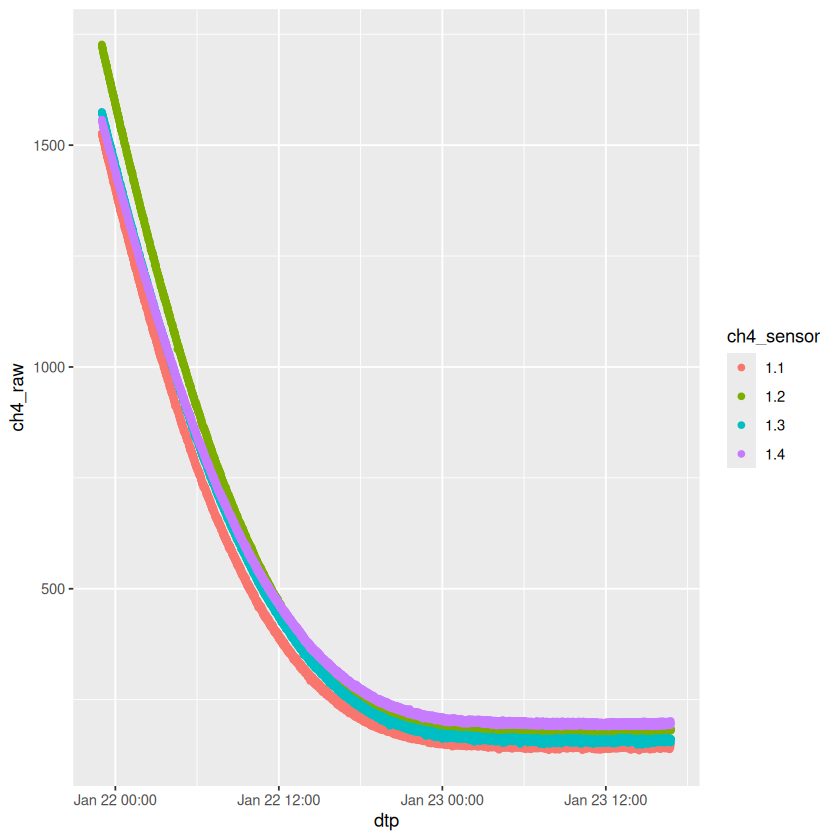

In [57]:
ch4_comb_selected <- ch4_comb[,c("ch4_sensor","time.s","ch4_raw","dtp","ch4_abb")]
 
ggplot(ch4_comb_selected, aes(dtp, ch4_raw, color=ch4_sensor)) + geom_point()

ch4_comb_gam <- gam(ch4_abb~ s(ch4_raw,k = 20)+s(aht_RH,k = 20)+s(aht_C,k = 20), drop.intercept = FALSE, data=ch4_comb)

summary(ch4_comb_gam)

As we can see, our GAM produced a strong R-squared value! If you need a refresher in statistics, that value tells us how well our model explains the variation seen in the dataset (i.e., goodness of fit). In this case, it suggests our model does a good job of fitting the variability in the data.

## Summary

Well there you have it! You have just engaged in the workflow typical of calibrating environmental sensors. As you may have noticed, the steps are generally the same at each level of concentration. We started by running models for each individual sensor, then we combined all the data and ran a GAM with all of the data we have. This is the general approach you have to take towards calibration. Each trial you conduct, you should follow the same workflow and then continue combining all of your data into a grand model because the more data you can put in, the stronger the model will be. Good luck with your sensor calibration!